In [77]:
#Import packages etc
import os
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime


In [78]:
def read_csv_files(directory):
    csv_files = []
    print(f"Checking files in directory: {directory}")
    for filename in os.listdir(directory):
        if filename.startswith("sub") and filename.endswith(".csv"):
            print(f"Reading CSV file: {filename}")
            file_path = os.path.join(directory, filename)
            df = pd.read_csv(file_path)
            csv_files.append(df)
        else:
            print(f"Skipping file: {filename}")
    return csv_files

def map_prolific_ids(dataframe):
    unique_ids = dataframe['prolific_id'].unique()
    id_mapping = {id: (i % 100) + 1 for i, id in enumerate(unique_ids)}
    dataframe['prolific_id'] = dataframe['prolific_id'].map(id_mapping)
    return dataframe, id_mapping

# Get data
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, 'data')

# Load the task data only once
task_data_path = os.path.join(data_directory, 'task_data_nobehav.csv')
if os.path.exists(task_data_path):
    task_data = pd.read_csv(task_data_path)
    print(task_data.head())

# Call the function and get the list of dataframes
dataframes = read_csv_files(data_directory)

# Ensure task_data is not included in the dataframes list
dataframes = [df for df in dataframes if not df.equals(task_data)]

# Display the first few rows of each DataFrame and the 'effLevel' column
for i, df in enumerate(dataframes):
    print(f"First few rows of DataFrame {i+1}:")
    print(df.head())

# Concatenate all DataFrames into one
big_dataframe = pd.concat(dataframes, ignore_index=True)

# Get current date and time
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
id_mapping_df_var_name = f"id_mapping_df_{current_time}"

# Map prolific_id to numbers 1-100
big_dataframe,id_mapping_df = map_prolific_ids(big_dataframe)

   Points                                      FeedbackText1  \
0       2          You reached the planet, you get 2 rubies!   
1       2          You reached the planet, you get 2 rubies!   
2       0  You reached the planet, but a space pirate alr...   
3       0  You reached the planet, but a space pirate alr...   
4       1            You reached the planet, you get 1 ruby!   

                                       FeedbackText2         stimFile  \
0  You did not have enough fuel to reach the plan...  stim/image2.png   
1  You did not have enough fuel to reach the plan...  stim/image2.png   
2  You did not have enough fuel to reach the plan...    stim/None.png   
3  You did not have enough fuel to reach the plan...    stim/None.png   
4  You did not have enough fuel to reach the plan...  stim/image1.png   

   effLevel  
0        48  
1        63  
2        50  
3        27  
4        24  
Checking files in directory: /Users/alisaloosen/Documents/GitHub/EffRewLearning _RLModelSim/

In [79]:

# Adapt the task_data to match the simulation scripts
task_data.rename(columns={'Points': 'reward', 'effLevel': 'threshold'}, inplace=True)
task_data = task_data[['reward', 'threshold']]
print(task_data.head())

   reward  threshold
0       2         48
1       2         63
2       0         50
3       0         27
4       1         24


In [80]:
class RewardLearner:
    """
    Implements the Reward Learner using a simple Rescorla-Wagner update:
      R_hat[t] = R_hat[t-1] + alpha_r * (R_t - R_hat[t-1])
    """
    def __init__(self, alpha_r=0.1, init_reward=3.5, sigma_r=0.7):
        """
        alpha_r : learning rate for reward
        init_reward : initial expectation of reward (R_hat[1]); could be rating
        sigma_r : fixed uncertainty in reward belief
        """
        self.alpha_r = alpha_r
        self.R_hat = init_reward #/ 7.0 # normalized rewards
    
    def update(self, received_reward):
        """
        Update R_hat based on received_reward, returning the updated R_hat.
        """
         #normalized_reward = received_reward / 7.0  # Normalize received reward
        # Prediction error
        delta_r = received_reward - self.R_hat
        # RW update
        self.R_hat += self.alpha_r * delta_r
        return self.R_hat
    
    def belief_distribution(self):
        """
        Returns a normal distribution mean R_hat, std sigma_r.
        Could be used to compare with participant reward ratings if desired.
        """
        return norm(loc=self.R_hat, scale=self.sigma_r)

In [81]:
class EffortLearner:
    """
    Implements the Effort Learner with direct threshold feedback:
      E_hat[t+1] = E_hat[t] + alpha_e * (theta[t] - E_hat[t])
    """
    def __init__(self, alpha_e=0.1, init_effort=50.0):
        """
        alpha_e : learning rate for effort
        init_effort : initial expectation of required effort (E_hat[1])
        """
        self.alpha_e = alpha_e
        self.E_hat = init_effort #/ 100.0  # Normalize initial effort
    
    def update(self, true_threshold):
        """
        E_hat[t+1] = E_hat[t] + alpha_e * (true_threshold - E_hat[t])
        """
        #normalized_threshold = true_threshold / 100.0  # Normalize threshold
        delta_e = true_threshold - self.E_hat
        self.E_hat += self.alpha_e * delta_e
        # Bound E_hat to [0,100]
        self.E_hat = np.clip(self.E_hat, 0, 100)
        return self.E_hat


In [82]:
class EffortDiscounter:
    def __init__(self, kappa=0.5, sigma=7.0, beta=5.0, policy='argmax'):
        """
        kappa : effort sensitivity
        sigma : noise/uncertainty for success probability
        beta  : inverse temperature for softmax
        policy: 'argmax' or 'softmax'
        """
        self.kappa = kappa
        self.sigma = sigma
        self.beta = beta
        self.policy = policy

    def choose_effort(self, R_hat, E_hat):
        """
        We enumerate e in [0..100], compute:
          p_success(e) = norm.cdf( (e - E_hat)/sigma )
          SV(e)        = R_hat - kappa* e
          EU(e)        = SV(e)* p_success(e)
        
        If policy == 'argmax', pick e that maximizes EU(e).
        If policy == 'softmax', sample e proportionally to exp(beta*EU(e)).
        """
        e_values = np.arange(101)
        EU_values = []

        # 1) Compute expected utility for each candidate effort e
        for e in e_values:
            p_success = norm.cdf((e - E_hat) / self.sigma)
            SV = R_hat - self.kappa * e
            EU = SV * p_success
            EU_values.append(EU)

        # 2) Decide
        EU_values = np.array(EU_values)
        if self.policy == 'argmax':
            chosen_e = e_values[np.argmax(EU_values)]
        else:
            # softmax sampling
            # subtract max for numerical stability
            max_eu = np.max(EU_values)
            exp_vals = np.exp(self.beta * (EU_values - max_eu))
            probs = exp_vals / np.sum(exp_vals)
            chosen_e = np.random.choice(e_values, p=probs)

        print(f"Chosen effort: {chosen_e}")
        return chosen_e


In [83]:
def simulate_experiment(num_trials=50,
                        reward_learner_params=None,
                        effort_learner_params=None,
                        discounter_params=None,
                        data=None,
                        ignore_zero_reward=True):
    if reward_learner_params is None:
        reward_learner_params = {}
    if effort_learner_params is None:
        effort_learner_params = {}
    if discounter_params is None:
        discounter_params = {}

    RL = RewardLearner(**reward_learner_params)
    EL = EffortLearner(**effort_learner_params)
    discounter = EffortDiscounter(**discounter_params)

    results = {
        'trial': [],
        'threshold': [],
        'reward': [],
        'chosen_effort': [],
        'outcome': [],
        'R_hat': [],
        'E_hat': []
    }

    for t in range(1, num_trials+1):
        if data is not None:
            threshold = data.iloc[t-1]['threshold']
            reward = data.iloc[t-1]['reward']
        else:
            threshold = np.random.uniform(20, 100)
            reward = np.random.uniform(1, 100)

        if ignore_zero_reward and reward == 0:
            print(f"Trial {t}: Skipping zero-reward trial")
            continue

        R_hat_t = RL.R_hat
        E_hat_t = EL.E_hat

        chosen_e = discounter.choose_effort(R_hat_t, E_hat_t)

        p_success = norm.cdf((chosen_e - E_hat_t) / discounter.sigma)
        outcome = np.random.binomial(1, p_success)

        received_reward = reward if outcome == 1 else 0.0
        RL.update(received_reward)
        EL.update(threshold)

        # Debugging prints
        print(f"Trial {t}: R_hat = {RL.R_hat}, E_hat = {EL.E_hat}, chosen_e = {chosen_e}")

        results['trial'].append(t)
        results['threshold'].append(threshold)
        results['reward'].append(reward)
        results['chosen_effort'].append(chosen_e)
        results['outcome'].append(outcome)
        results['R_hat'].append(RL.R_hat)
        results['E_hat'].append(EL.E_hat)

    return results


Chosen effort: 70
Trial 1: R_hat = 29.1970125654709, E_hat = 78.63099023828435, chosen_e = 70
Chosen effort: 97
Trial 2: R_hat = 22.606415137295578, E_hat = 34.667435328427636, chosen_e = 97
Chosen effort: 52
Trial 3: R_hat = 46.32604816892659, E_hat = 75.6907716019256, chosen_e = 52
Chosen effort: 95
Trial 4: R_hat = 31.712944746752616, E_hat = 90.93470214341909, chosen_e = 95
Chosen effort: 100
Trial 5: R_hat = 15.856472373376308, E_hat = 53.26994137087713, chosen_e = 100
Chosen effort: 69
Trial 6: R_hat = 31.576328061044308, E_hat = 77.70407627526694, chosen_e = 69
Chosen effort: 96
Trial 7: R_hat = 40.10876329100967, E_hat = 40.85740943944969, chosen_e = 96
Chosen effort: 60
Trial 8: R_hat = 63.005990800156326, E_hat = 48.190473981247266, chosen_e = 60
Chosen effort: 69
Trial 9: R_hat = 38.29945834255457, E_hat = 85.94472476372539, chosen_e = 69
Chosen effort: 100
Trial 10: R_hat = 59.06752235811957, E_hat = 58.2060891261968, chosen_e = 100
Chosen effort: 78
Trial 11: R_hat = 67.00

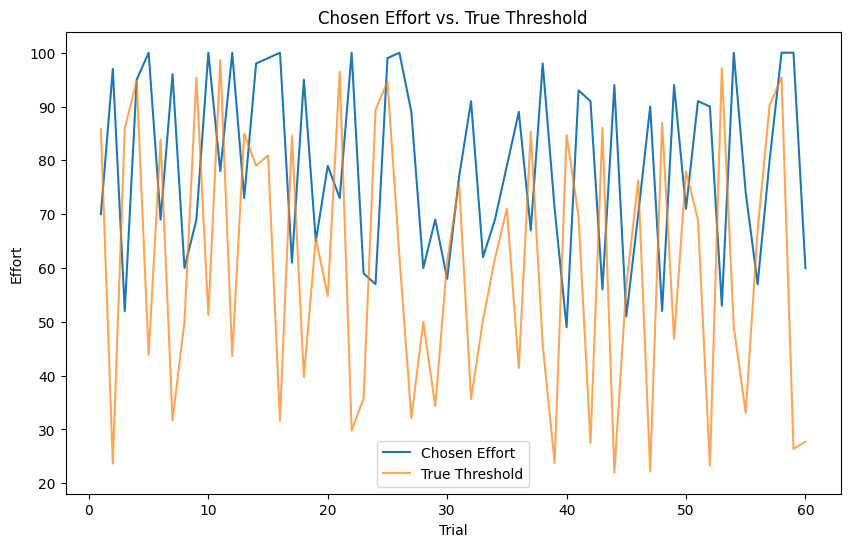

In [84]:
def main():
    # Example usage: simulate 50 trials with random threshold & reward
    # purely deterministic policy (argmax)
    discounter_params = {'kappa':0.05, 'sigma':7.0, 'beta':5.0, 'policy':'argmax'}
    
    sim_results = simulate_experiment(
        num_trials=len(task_data),
        reward_learner_params={'alpha_r':0.5, 'init_reward':50},
        effort_learner_params={'alpha_e':0.8, 'init_effort':50.0},
        discounter_params=discounter_params,
        data=None,#task_data,  # Ensure task_data is defined and passed correctly
        ignore_zero_reward=True  # Set to False if you don't want to ignore zero-reward trials
    )
    
    # Let's do a quick plot: chosen_effort & threshold
    trials = sim_results['trial']
    chosen_effort = sim_results['chosen_effort']
    threshold     = sim_results['threshold']
    
    plt.figure(figsize=(10,6))
    plt.plot(trials, chosen_effort, label='Chosen Effort')
    plt.plot(trials, threshold, label='True Threshold', alpha=0.7)
    plt.xlabel('Trial')
    plt.ylabel('Effort')
    plt.title('Chosen Effort vs. True Threshold')
    plt.legend()
    plt.show()
    
    # If we had pilot data, we would do something like:
    # data = load_my_pilot_data()  # a list of dicts or something
    # results_with_data = simulate_experiment(
    #     num_trials=len(data),
    #     reward_learner_params=...,
    #     effort_learner_params=...,
    #     discounter_params=...,
    #     data=data
    # )
    # Then do the same plotting but using real thresholds & rewards.

# Ensure to call the main function
main()

[5, 2, 6, 3, 4]
[2, 3, 4, 5, 6]
